# Tills system

The purpose of this assignment was to build fully functioning tills system which facilitates full functionality of the front end whilst capturing all transactions and sales on the backend.

In [1]:
import sqlite3

The first step to building the tills is to initialise the back-end SQL tables.
In addition to the products tables provided 2 new tables were created
The transactions table which recorded all transaction completed and the sales table which recorded all items purchased

In [2]:
# Create a database in RAM 

db = sqlite3.connect('tillsDb.db')

cursor = db.cursor()

cursor.execute('DROP TABLE IF EXISTS products')
cursor.execute('DROP TABLE IF EXISTS shift')
cursor.execute('DROP TABLE IF EXISTS payment_method')


#drop if sales and transactions exist

cursor.execute('DROP TABLE IF EXISTS sales')
cursor.execute('DROP TABLE IF EXISTS transactions')


#create sales and transactions table

cursor.execute('CREATE TABLE transactions (transactionId INTEGER PRIMARY KEY AUTOINCREMENT, totalCost REAL, totalPaid REAL, change REAL, paymentType INTEGER, date TEXT)') 
cursor.execute('CREATE TABLE sales (saleId INTEGER PRIMARY KEY AUTOINCREMENT, productId INTEGER ,transactionId INTEGER,price REAL,quantity INTEGER,isRefund INTEGER,FOREIGN KEY(productID) REFERENCES products(productid),FOREIGN KEY(transactionId) REFERENCES transactions(transactionId))')


In [3]:
#load tables from txt file
cursor = db.cursor()

filepath = 'products.txt'  
with open(filepath) as fp:  
    line = fp.readline()
    print(line)
    cursor.execute(line)
    cnt = 1
    while line:
        line = fp.readline()
        print(line)
        cursor.execute(line)
        cnt += 1

CREATE TABLE products (productid INT PRIMARY KEY, pos INT, name TEXT, classid INT, shift INT, price INT, plu TEXT);

INSERT INTO products VALUES(1,1,"Espresso",1,-2,130,"");

INSERT INTO products VALUES(2,2,"Americano",1,-2,180,"");

INSERT INTO products VALUES(3,3,"Latte",1,-2,200,"");

INSERT INTO products VALUES(4,4,"Cappuccino",1,-2,200,"");

INSERT INTO products VALUES(5,5,"Mocha",1,-2,220,"");

INSERT INTO products VALUES(6,6,"Hot Chocolate",1,-2,210,"");

INSERT INTO products VALUES(7,7,"English Breakfast Tea",1,-2,195,"");

INSERT INTO products VALUES(8,8,"Red Berry Tea",1,-2,195,"");

INSERT INTO products VALUES(9,9,"Camomile Tea",1,-2,195,"");

INSERT INTO products VALUES(10,10,"Earl Grey Tea",1,-2,195,"");

INSERT INTO products VALUES(11,11,"Peppermint Tea",1,-2,195,"");

INSERT INTO products VALUES(12,12,"Green Tea Luponde",1,-2,195,"");

INSERT INTO products VALUES(13,1,"Espresso",2,1,110,"");

INSERT INTO products VALUES(14,2,"Americano",2,1,160,"");

INSERT INTO products

Next we construct the till system

In [ ]:
#!/usr/bin/env python
"""
Very simple HTTP server in python.
Usage::
    ./dummy-web-server.py [<port>]
Send a GET request::
    curl http://localhost
Send a HEAD request::
    curl -I http://localhost
Send a POST request::
    curl -d "foo=bar&bin=baz" http://localhost
"""
#from BaseHTTPServer import BaseHTTPRequestHandler, HTTPServer
from http.server import BaseHTTPRequestHandler, HTTPServer # python 2 ammendment
#import SocketServer
import socketserver

import base64
import numpy as np

strtTrans = True


global transactionId


    
def build_action_refill(where,what):
    text = "<action>\n"
    text += "<type>refill</type>\n"
    text += "<where>"+where+"</where>\n"
    text += "<what>"+base64.b64encode(what.encode("utf-8")).decode("ascii")+"</what>\n"
    text += "</action>\n"
    
    return text

def build_action_append(where,what):
    text = "<action>\n"
    text += "<type>append</type>\n"
    text += "<where>"+where+"</where>\n"
    text += "<what>"+base64.b64encode(what.encode("utf-8")).decode("ascii")+"</what>\n" # encoding modifications
    text += "</action>\n"

    return text

def build_action_total(value):
    text = "<action>\n"
    text += "<type>total</type>\n"
    text += "<value>"+str(value)+"</value>\n" # string 2 to 3
    text += "</action>\n"

    return text

def build_action_reset():
    text = "<action>\n"
    text += "<type>reset</type>\n"
    text += "</action>\n"

    return text

def createTransaction():
    #creates a new transaction in the transaction table and returns its id
    cursor.execute('INSERT into transactions(totalCost, totalPaid, change, paymentType, date) Values(null,null,null,null,null)')
    cursor.execute("SELECT MAX(transactionId) FROM transactions")
    db.commit()
    transactionId = cursor.fetchone()
    return transactionId[0]
    
def Program (dictParts,strtTrans):
    
    #function which is called if a program button is selected
    #new transaction
    if strtTrans == True:
        transactionId = createTransaction()
        strtTrans = False
    else:
        cursor.execute("SELECT MAX(transactionId) FROM transactions")
        transactionId = cursor.fetchone()
        transactionId = transactionId[0]

        
    #query to return item selected and its price
    if int(dictParts['shift']) == 0:

        cursor.execute("SELECT name, price, productid FROM products WHERE pos = {} and shift <= {}".format(int(dictParts['pos']),int(dictParts['shift'])))
    else:
        cursor.execute("SELECT name, price, productid FROM products WHERE pos = {} and shift in ({},{})".format(int(dictParts['pos']),int(dictParts['shift']), int(dictParts['shift'])*-1))
    retItem = cursor.fetchone()

    item = ''
    price = 0
    #if retItem:
    item = retItem[0]
    price = retItem[1]
    productId = retItem[2]

    #if its a refund make the price negative
    isRefund = 0

    if int(dictParts['refund']) == 4:
        price = price*-1
        isRefund = 1
    #quantity of item
    quantity = dictParts['num']
    #insert values into sales table
    cursor.execute('INSERT into sales(transactionId, productId, quantity, isRefund, price)\
    Values({},{},{},{},{})'.format(transactionId,productId,int(dictParts['num']),isRefund,price))
    cursor.execute('SELECT * from sales')
    db.commit()

    
    #calculate running totals
    cursor.execute('select sum(price*quantity) FROM sales WHERE transactionId = {} GROUP BY transactionId'.format(transactionId))
    totalCost = cursor.fetchall()

    totalCost = np.sum(totalCost)
    #else:
        #item = 'invalid item'
        #return
    return item, price, transactionId, productId, quantity, isRefund, totalCost, strtTrans

def plu(dictParts,strtTrans):
    #function is called if action is plu
    
    #if new transaction
    if strtTrans== True:
        transactionId = createTransaction()
        strtTrans = False
    else:
        cursor.execute("SELECT MAX(transactionId) FROM transactions")
        transactionId = cursor.fetchone()
        transactionId = transactionId[0]

    
    #calculate running totals
    cursor.execute('select sum(price*quantity) FROM sales WHERE transactionId = {} GROUP \
    BY transactionId'.format(transactionId))
    totalCost = cursor.fetchone()
    totalCost = np.sum(totalCost)

    
    if dictParts['plu'] != '':
        #query item based on plu code
        cursor.execute("SELECT name, price FROM products WHERE plu = {}".format(int(dictParts['plu'])))
        retItem = cursor.fetchone()

        item = ''
        price = 0
        if retItem:
            item = retItem[0]
            price = retItem[1]

            isRefund = 0
            if int(dictParts['refund']) == 4:
                price = price*-1
                isRefund = 1

            quantity = dictParts['num']

            cursor.execute("SELECT productid FROM products WHERE plu = {}".format(int(dictParts['plu']))) 
            productId = cursor.fetchall()[0]
            productId = productId[0]
  
            #enter values into sales table
            cursor.execute('INSERT into sales(transactionId, productId, quantity, isRefund, price)\
            Values({},{},{},{},{})'.format(transactionId,productId,int(dictParts['num']),isRefund,price))

            db.commit()
        else:
            #return invalid item and invalid = 1 if plu not found
            item = 'invalid item'
            invalid = 1
            return transactionId, totalCost, invalid
    else:
        item = 'invalid item'

        invalid = 1
        return transactionId, totalCost, invalid
        #calculate running totals

    cursor.execute('select sum(price*quantity) FROM sales WHERE transactionId = {} GROUP \
    BY transactionId'.format(transactionId))
    totalCost = cursor.fetchone()
    totalCost = np.sum(totalCost)
    invalid = 0
    
    return transactionId, totalCost, invalid

def cash(dictParts, strtTrans, totalCost, totalPaid):
    #function to be called if action = cash
    paymentType = dictParts['type']

    cursor.execute("SELECT MAX(transactionId) FROM transactions")
    transactionId = cursor.fetchone()
    transactionId = transactionId[0]
    #update transactions

    change = float(totalPaid) - totalCost
    #if paid greater than total cost then transaction is complete
    #update transaction table for this transaction
    
    cursor.execute('UPDATE transactions SET totalCost = {}, totalPaid = {}, change ={}, paymentType = {}, date = date("now") WHERE transactionId = {}'.format(totalCost,totalPaid,change,paymentType,transactionId))
    db.commit()
    strtTrans = True


    return strtTrans, change


def clear(dictParts,transactionId):
    #remove entries from databases if void selected
    cursor.execute('DELETE FROM sales WHERE transactionId = {}'.format(transactionId))
    cursor.execute('DELETE FROM transactions WHERE transactionId = {}'.format(transactionId))
    #keeps primary key sequenctional in transactions table
    cursor.execute('DELETE FROM sqlite_sequence WHERE name = "transactions"')
    x = createTransaction()
    strtTrans = False
    return strtTrans


def mealDeal(transactionId, paid=0):
    #calculates meal deals
    
    import itertools as it
    
    
    #hot drinks and cookies meal deal
    
    #select all hot drinks purchased
    
    cursor.execute('SELECT products.name,sales.quantity FROM (products JOIN sales ON products.productId=sales.productId)\
    WHERE sales.transactionId = {} AND products.classid in (1, 2, 3) AND sales.isRefund = 0'.format(transactionId))
    custHotDrinks = cursor.fetchall()
    custHotDrinksList = []
    for i in range(len(custHotDrinks)):
        for freq in range(custHotDrinks[i][1]):
            custHotDrinksList.append(custHotDrinks[i][0])
    
    
    #remove refunds
    cursor.execute('SELECT products.name,sales.quantity FROM (products JOIN sales ON products.productId=sales.productId)\
    WHERE sales.transactionId = {} AND products.classid in (1, 2, 3) AND sales.isRefund = 1'.format(transactionId))
    
    hotDrinksRefunds = cursor.fetchall()
    hotDrinksRefundList = []
    for i in range(len(hotDrinksRefunds)):
        for freq in range(hotDrinksRefunds[i][1]):
            hotDrinksRefundList.append(hotDrinksRefunds[i][0])
    
    for ref in hotDrinksRefundList:
        if ref in custHotDrinksList:
            custHotDrinksList.remove(ref) 

    
    #cust cookies purchased
    cursor.execute('SELECT products.name,sales.quantity FROM (products JOIN sales ON products.productId=sales.productId)\
    WHERE sales.transactionId = {} AND products.productid in(66, 67, 68) AND sales.isRefund = 0'.format(transactionId))
    custCook = cursor.fetchall()
    custCookList = []
    for i in range(len(custCook)):
        for freq in range(custCook[i][1]):
            custCookList.append(custCook[i][0])
        
    #remove refunds
    cursor.execute('SELECT products.name,sales.quantity FROM (products JOIN sales ON products.productId=sales.productId)\
    WHERE sales.transactionId = {} AND products.productid in(66, 67, 68) AND sales.isRefund = 1'.format(transactionId))
    
    cookRefunds = cursor.fetchall()
    cookRefundList = []
    for i in range(len(cookRefunds)):
        for freq in range(cookRefunds[i][1]):
            cookRefundList.append(cookRefunds[i][0])
    
    for ref in cookRefundList:
        if ref in custCookList:
            custCookList.remove(ref) 
    #take minimum of the two and refund half price of the cookie
    cookieRefundNum = min(len(custCookList),len(custHotDrinksList))
    cookieRefund = round(32.5*cookieRefundNum,2)

    
    drinksUsed = custHotDrinksList[:cookieRefundNum]
    
    
    
    #snacks, sandwiches, drinks
    #all combinations of 
    #all sandwhiches in product table
    cursor.execute('SELECT name FROM products WHERE products.classid in(5, 7)')
    sandwhich = cursor.fetchall()
    sandList = [x[0] for x in sandwhich]
    
    #all drinks
    cursor.execute('SELECT name FROM products WHERE products.classid in(1, 4)')
    drinks = cursor.fetchall()
    drinksList = [x[0] for x in drinks]
    
    #all snacks
    cursor.execute('SELECT name FROM products WHERE products.productid in(65,  69, 70, 71, 72)')
    snacks = cursor.fetchall()
    snacksList = [x[0] for x in snacks]
    
    #build combination of all snacks drinks and sandwiches
    dealsComb = []
    for combination in it.product(sandList, drinksList, snacksList):
        #print combination
        dealsComb.append(combination)
    

    
    #cust sandwhiches remove refunds
    cursor.execute('SELECT products.name,sales.quantity FROM (products JOIN sales ON products.productId=sales.productId)\
    WHERE sales.transactionId = {} AND products.classid in (5, 7) AND sales.isRefund = 0'.format(transactionId))
    custSandwhich = cursor.fetchall()
    custSandList = []
    for i in range(len(custSandwhich)):
        for freq in range(custSandwhich[i][1]):
            custSandList.append(custSandwhich[i][0])
    
    
    #remove refunds
    cursor.execute('SELECT products.name,sales.quantity FROM (products JOIN sales ON products.productId=sales.productId)\
    WHERE sales.transactionId = {} AND products.classid in (5, 7) AND sales.isRefund = 1'.format(transactionId))
    
    sandRefunds = cursor.fetchall()
    SandRefundList = []
    for i in range(len(sandRefunds)):
        for freq in range(sandRefunds[i][1]):
            SandRefundList.append(sandRefunds[i][0])
    
    for ref in SandRefundList:
        if ref in custSandList:
            custSandList.remove(ref)
    
    
    #cust drinks 
    cursor.execute('SELECT products.name,sales.quantity FROM (products JOIN sales ON products.productId=sales.productId)\
    WHERE sales.transactionId = {} AND products.classid in (1, 2, 3 , 4) AND sales.isRefund = 0'.format(transactionId))
    custDrinks = cursor.fetchall()
    custDrinksList = []
    for i in range(len(custDrinks)):
        for freq in range(custDrinks[i][1]):
            custDrinksList.append(custDrinks[i][0])
    
    #remove previously used drinks
    for drink in drinksUsed:
        if drink in custDrinksList:
            custDrinksList.remove(drink)
    
    #remove refunds
    cursor.execute('SELECT products.name,sales.quantity FROM (products JOIN sales ON products.productId=sales.productId)\
    WHERE sales.transactionId = {} AND products.classid in (1, 2, 3, 4) AND sales.isRefund = 1'.format(transactionId))
    
    drinksRefunds = cursor.fetchall()
    drinksRefundList = []
    for i in range(len(drinksRefunds)):
        for freq in range(drinksRefunds[i][1]):
            drinksRefundList.append(drinksRefunds[i][0])
    
    for ref in drinksRefundList:
        if ref in custDrinksList:
            custDrinksList.remove(ref) 
        
    #cust snacks
    cursor.execute('SELECT products.name,sales.quantity FROM (products JOIN sales ON products.productId=sales.productId)\
    WHERE sales.transactionId = {} AND products.productid in(65, 69, 70, 71, 72) AND sales.isRefund = 0'.format(transactionId))
    custSnacks = cursor.fetchall()
    custSnacksList = []
    for i in range(len(custSnacks)):
        for freq in range(custSnacks[i][1]):
            custSnacksList.append(custSnacks[i][0])
    
    
    #remove refunds
    cursor.execute('SELECT products.name,sales.quantity FROM (products JOIN sales ON products.productId=sales.productId)\
    WHERE sales.transactionId = {} AND products.productid in(65, 69, 70, 71, 72) AND sales.isRefund = 1'.format(transactionId))
    
    snacksRefunds = cursor.fetchall()
    snacksRefundList = []
    for i in range(len(snacksRefunds)):
        for freq in range(snacksRefunds[i][1]):
            snacksRefundList.append(snacksRefunds[i][0])
    
    for ref in snacksRefundList:
        if ref in custSnacksList:
            custSnacksList.remove(ref)
    
    
    
    #build list of all meal deal items purchased. use the minimim of these lengths as a bound
    refundNum = min(len(custSandList),len(custDrinksList),len(custSnacksList))
    
    custItemsList = []
    for i in range(0,refundNum):
        dealTuple = (custSandList[i],custDrinksList[i],custSnacksList[i])
        custItemsList.append(dealTuple)
    
    refundedItems = []
    drinksUsed = []
    for item in custItemsList:

        for deal in dealsComb:

            if item == deal:
                refundedItems.append(deal[2])

                
    #for all items refund query their price and append to list
    dealRefund = []
    for ref in refundedItems:
        ref = "'"+ref+"'"
        cursor.execute("SELECT price FROM products WHERE products.name = {}".format(ref))
        dealRefund.append(cursor.fetchone()[0])

    #total refunded
    
    totalDealRefund  = sum(dealRefund) + cookieRefund
    
    #if cash has been paid update the sales table with the refund
    #default value for paid = 0
    if paid == 1:
           
        #insert refund into sales table

        for i in range(len(dealRefund)):
            #add deal to refund table
            cursor.execute('INSERT into sales(transactionId, productId, quantity, isRefund, price) Values({},"MD1",1,1,{})'.format(transactionId,(dealRefund[i]*-1)))
            db.commit()


        #second refund
        for i in range(cookieRefundNum):
            #add deal to refund table
            cursor.execute('INSERT into sales(transactionId, productId, quantity, isRefund, price) Values({},"MD2",1,1,{})'.format(transactionId,-65))
            db.commit()
    return totalDealRefund 
    #cursor.execute('INSERT into sales(transactionId, quantity, isRefund, price) Values({},1,1,{})'.format(transactionId,totalDealRefund))
    
    
from urllib import parse
#parse.urlparse(self.path)
class S(BaseHTTPRequestHandler):
    global strtTrans
    def _set_headers(self):
        self.send_response(200)
        self.send_header('Content-type'.encode(), 'text/html'.encode())
        self.end_headers()
        
    def do_GET(self):
        """Respond to a GET request."""
        parse.urlparse(self.path)
        parts = self.path.split("?",1);     

        pathParts = parse.urlparse(self.path)
        
        if (self.path == '/'):
            self.send_response(200)
            fname = 'till.html';
            file = open(fname,"r")
            text = file.read()
            self.send_header('Content-type'.encode(), 'text/html'.encode())
        elif (self.path == '/till.css'):
            self.send_response(200)
            fname = 'till.css';
            file = open(fname,"r")
            text = file.read()
            self.send_header('Content-type'.encode(), 'text/css'.encode())
        elif (self.path == '/till2.html'):
            self.send_response(200)
            fname = 'till2.html';
            file = open(fname,"r")
            text = file.read()
            self.send_header('Content-type'.encode(), 'text/html'.encode())
        elif (self.path == '/till.js'):
            self.send_response(200)
            fname = 'till.js';
            file = open(fname,"r")
            text = file.read()
            self.send_header('Content-type'.encode(), 'application/javascript'.encode())
        elif (parts[0] == '/action'):
            self.send_response(200)
            #cursor = db.cursor
            global strtTrans
            subtext = "";
            
            #build diction of split path can be used to identify the icon
            dictParts = {}
            for p in parts[1].split("&"):
                key, val = p.split("=")
                dictParts[key] = val
                #subtext = subtext + key + '=' + val +"<br>";

            
            #set defualt values to constants
            paid = 1
            totalCost = 0
            change = 0.00
            invalid = 0
            deal = 0
            #create transaction if needed
            if strtTrans == False:
                cursor.execute("SELECT MAX(transactionId) FROM transactions")
                transactionId = cursor.fetchone()
                transactionId = transactionId[0]
            
            #if program button
            if dictParts['action'] == 'program':
                item, price, transactionId, productId, quantity, isRefund, totalCost,strtTrans = Program (dictParts,strtTrans)
                #subtext += item + " Price:"+str(price)+"<br>"
                
                #calculate deal to display in total box
                deal = mealDeal(transactionId)  
            #if program = plu
            if dictParts['action'] == 'plu':
                #item, price, transactionId, productId, quantity, isRefund,totalCost = plu (dictParts,strtTrans)
                transactionId, totalCost, invalid = plu(dictParts,strtTrans)
                #calculate meal deal to be displayed
                deal = mealDeal(transactionId)  
                #subtext += item + " Price:"+str(price)+"<br>"
            if dictParts['action'] == 'cash':
                #need to calculate totalPaid
    
                cursor.execute("SELECT MAX(transactionId) FROM transactions")
                transactionId = cursor.fetchone()
                transactionId = transactionId[0]
                
                deal = mealDeal(transactionId)
                
                #check total costs for the transaction
                cursor.execute('select sum(price*quantity) FROM sales WHERE transactionId = {} GROUP BY transactionId'.format(transactionId))
                totalCost = cursor.fetchall()
                totalPaid = dictParts['cash']
                totalCost = np.sum(totalCost)
                totalCost = totalCost-deal
                #if totalCost is more than amount paid then dont continue
                if float(totalPaid)<float(totalCost):

                    paid = 0
                else:
                    
                    #total paid is fine so transaction can be complete
                    deal = mealDeal(transactionId,paid =1)
                    strtTrans, change = cash(dictParts, strtTrans, totalCost, totalPaid)
                    change = change/100
                    
            if dictParts['action'] == 'clr' and strtTrans == False:
                strtTrans = clear(dictParts,transactionId)
            
            #makes compatible with both pages
            
            if dictParts['action'] == 'status' and strtTrans == False:
                deal = mealDeal(transactionId)
                cursor.execute('select sum(price*quantity) FROM sales WHERE transactionId = {} GROUP BY transactionId'.format(transactionId))
                totalCost = cursor.fetchall()
                totalCost = np.sum(totalCost)

        
            text  = '<?xml version="1.0" encoding="UTF-8"?>\n'
            text += "<response>\n"
            #where total is displayed
            
            #import math

            if strtTrans == True:
                text += build_action_total(totalCost);
            else:
                text += build_action_total(totalCost-deal);



            
            #extract all sales to paste into text box
            cursor.execute("SELECT MAX(transactionId) FROM transactions")
            transactionId = cursor.fetchone()
            transactionId = transactionId[0]
            if transactionId:
                cursor.execute('SELECT products.name, sales.price, sales.quantity, sales.transactionId FROM (products JOIN sales ON products.productId=sales.productId) WHERE sales.transactionId = {}'.format(transactionId))
                sales = cursor.fetchall()

                for i in range(0,len(sales)):
                    itemPrint = sales[i][0]
                    pricePrint = sales[i][1]
                    pricePrint = pricePrint/100
                    quantPrint = sales[i][2]
                    subtext += str(quantPrint) + " X " + itemPrint + " Price: &#163;"+str(pricePrint*quantPrint)+"<br>"
                #if meal not 0 then display it
                if deal != 0:
                    subtext += "meal deal refund: &#163;" + str(round(deal/100,2)) +"<br>"
                    
                   #FROM (products JOIN sales ON products.productId=sales.productId) 
            text += build_action_append("target", subtext);
            #title = title of the till
            if paid == 1:
                text += build_action_refill("title", "Change &pound;"+str(round(change,2)));
            else:
                text += build_action_refill("title",'Insufficient payment')
            
            if invalid == 1:
                text += build_action_refill("title",'Invalid PLU')
                
            text += build_action_reset();
            text += "</response>\n"

            self.send_header('Content-type', 'application/xml')
        else:
            self.send_response(404)
            fname = '404.html';
            file = open(fname,"r")
            text = file.read()
            self.send_header('Content-type', 'text/html')
            
        self.end_headers()
        self.wfile.write(text.encode())
    

    def do_HEAD(self):
        self._set_headers()
        
    def do_POST(self):
        self._set_hteeaders()
        self.wfile.write("<html><body><h1>POST!</h1></body></html>".encode())
        
def run(server_class=HTTPServer, handler_class=S, port=802):
    server_address = ('', port)
    httpd = server_class(server_address, handler_class)
    print ('Starting httpd...')
    httpd.serve_forever()

if __name__ == "__main__":
    from sys import argv

    if len(argv) == 2:
        run(port=int(argv[1]))
    else:
        run()


__Till actions and functions__

__Def CreateTransaction__
If the till is just opened or a transaction has just been completed the createTransaction function is used to create a new transaction. It works by inserting a new entry into the transactions data base and assigning all values except the primary key as null

__Def Program__
If a food/drink item is selected it is processed using def Program. First step is to check if it’s a new transaction. If it is a new the createTransaction functions is called, otherwise it continues. Next step is to run a query to identify which product was selected and its price. The fields used to achieve this are pos and shift. Each unique item has a pos number and its shift determines what size is selected. The query is built so that if the shift is 0 will look for the product with the corresponding pos number and shift <=0. If shift is greater than 0 it will look for the product which the corresponding pos number and shift of +shift or -shift. This is required to make it compatible with the products table. The next step is to check if it is a refund by checking dictParts[‘refund’]. If it is a refund assign the price to be negative and set isRefund = 1. The quantity of the items is also captured and is equal to the dictParts['num']. Once these values are known it is time to load the transactionId, productId, quantity, isRefund and price into the sales database. The total cost of the current transaction is then calculated using select query which sums the price * quantity for the current transactionId in the sales table and passes it back so it can be displayed on the till

__Def Clear__
If the cashier decides to void the payment dictParts['action ‘] = clear and the code enters into the clear function. This simply deletes all entries from the sales table and transactions table for the current transactionId and resets strtTrans = True to start a new transaction.

__Def Plu__
The Plu function works very similarly to the program function but instead of using pos and shift to identify which product has been selected, it uses the Plu number entered into the till. This is found in dictParts['plu']. For robustness an addition if condition is included to deal with invalid plu in which case the title displays invalid plu

__Def Cash__
Once the transaction is complete the and the customer is ready to pay the total amount paid is entered into the till and either the credit, debit or cash icon is selected. The code then checks if the amount paid is greater than or equal to the amount owed if not it displays “insufficient amount in the title”. If payment is greater than or equal to the amount owed the code enters into def cash which updates the transactions table. The payment type is also recorded using dictParts['type']. It updates the totalcost, totalpaid, change, paymentType and date (which is simply entered using data(“now”) columns in the transactions table corresponding to the current transactionId. It then resets strtTrans = True which signifies the transaction is complete and to start a new one.

__Def mealdeal__
An additional feature to the functionality of the till is to calculate 2 meal deal discounts. The code needs to calculate the discounts based on 2 separate meal deals. The first meal deal refunds half the price of a cookie if it is bought with a hot drink. This is done by running a query to check all hot drinks bought then a query to check all hot drink refunds and remove these to build the custdrinkList, multiples of drinks were also recorded. Then a query is run which returns all the cookies bought and one which returns all the refunded cookies removing these to build the cookieCookieList, multiples of cookies were also. The minimum of the length of the 2 lists is then multiplied by the price of a cookie to calculate the discount. The second meal produces a free snack when purchasing a sandwich and drink. To calculate this, separate lists of all snacks, all drinks and all sandwiches purchased by the customer were created by querying the sales table. All drinks used in deal 1 were then removed from the deal2 drinks list. The minimum length of these three lists was then used to calculate all the items in the deal producing a list of tuples called the custItemsList. Then using itertools all 3 item combinations of drinks sandwiches and snacks were calculated producing a list of tuples called dealsComb. Then for all items in both custItemsList and dealsComb a refund on the snack is given. The mealDeal function is called after any item is selected so that it can be displayed in the total. However, it‘s value is only updated to the sales database when the cash is being paid. This allows meal deals to be recalculated if there is a refund.


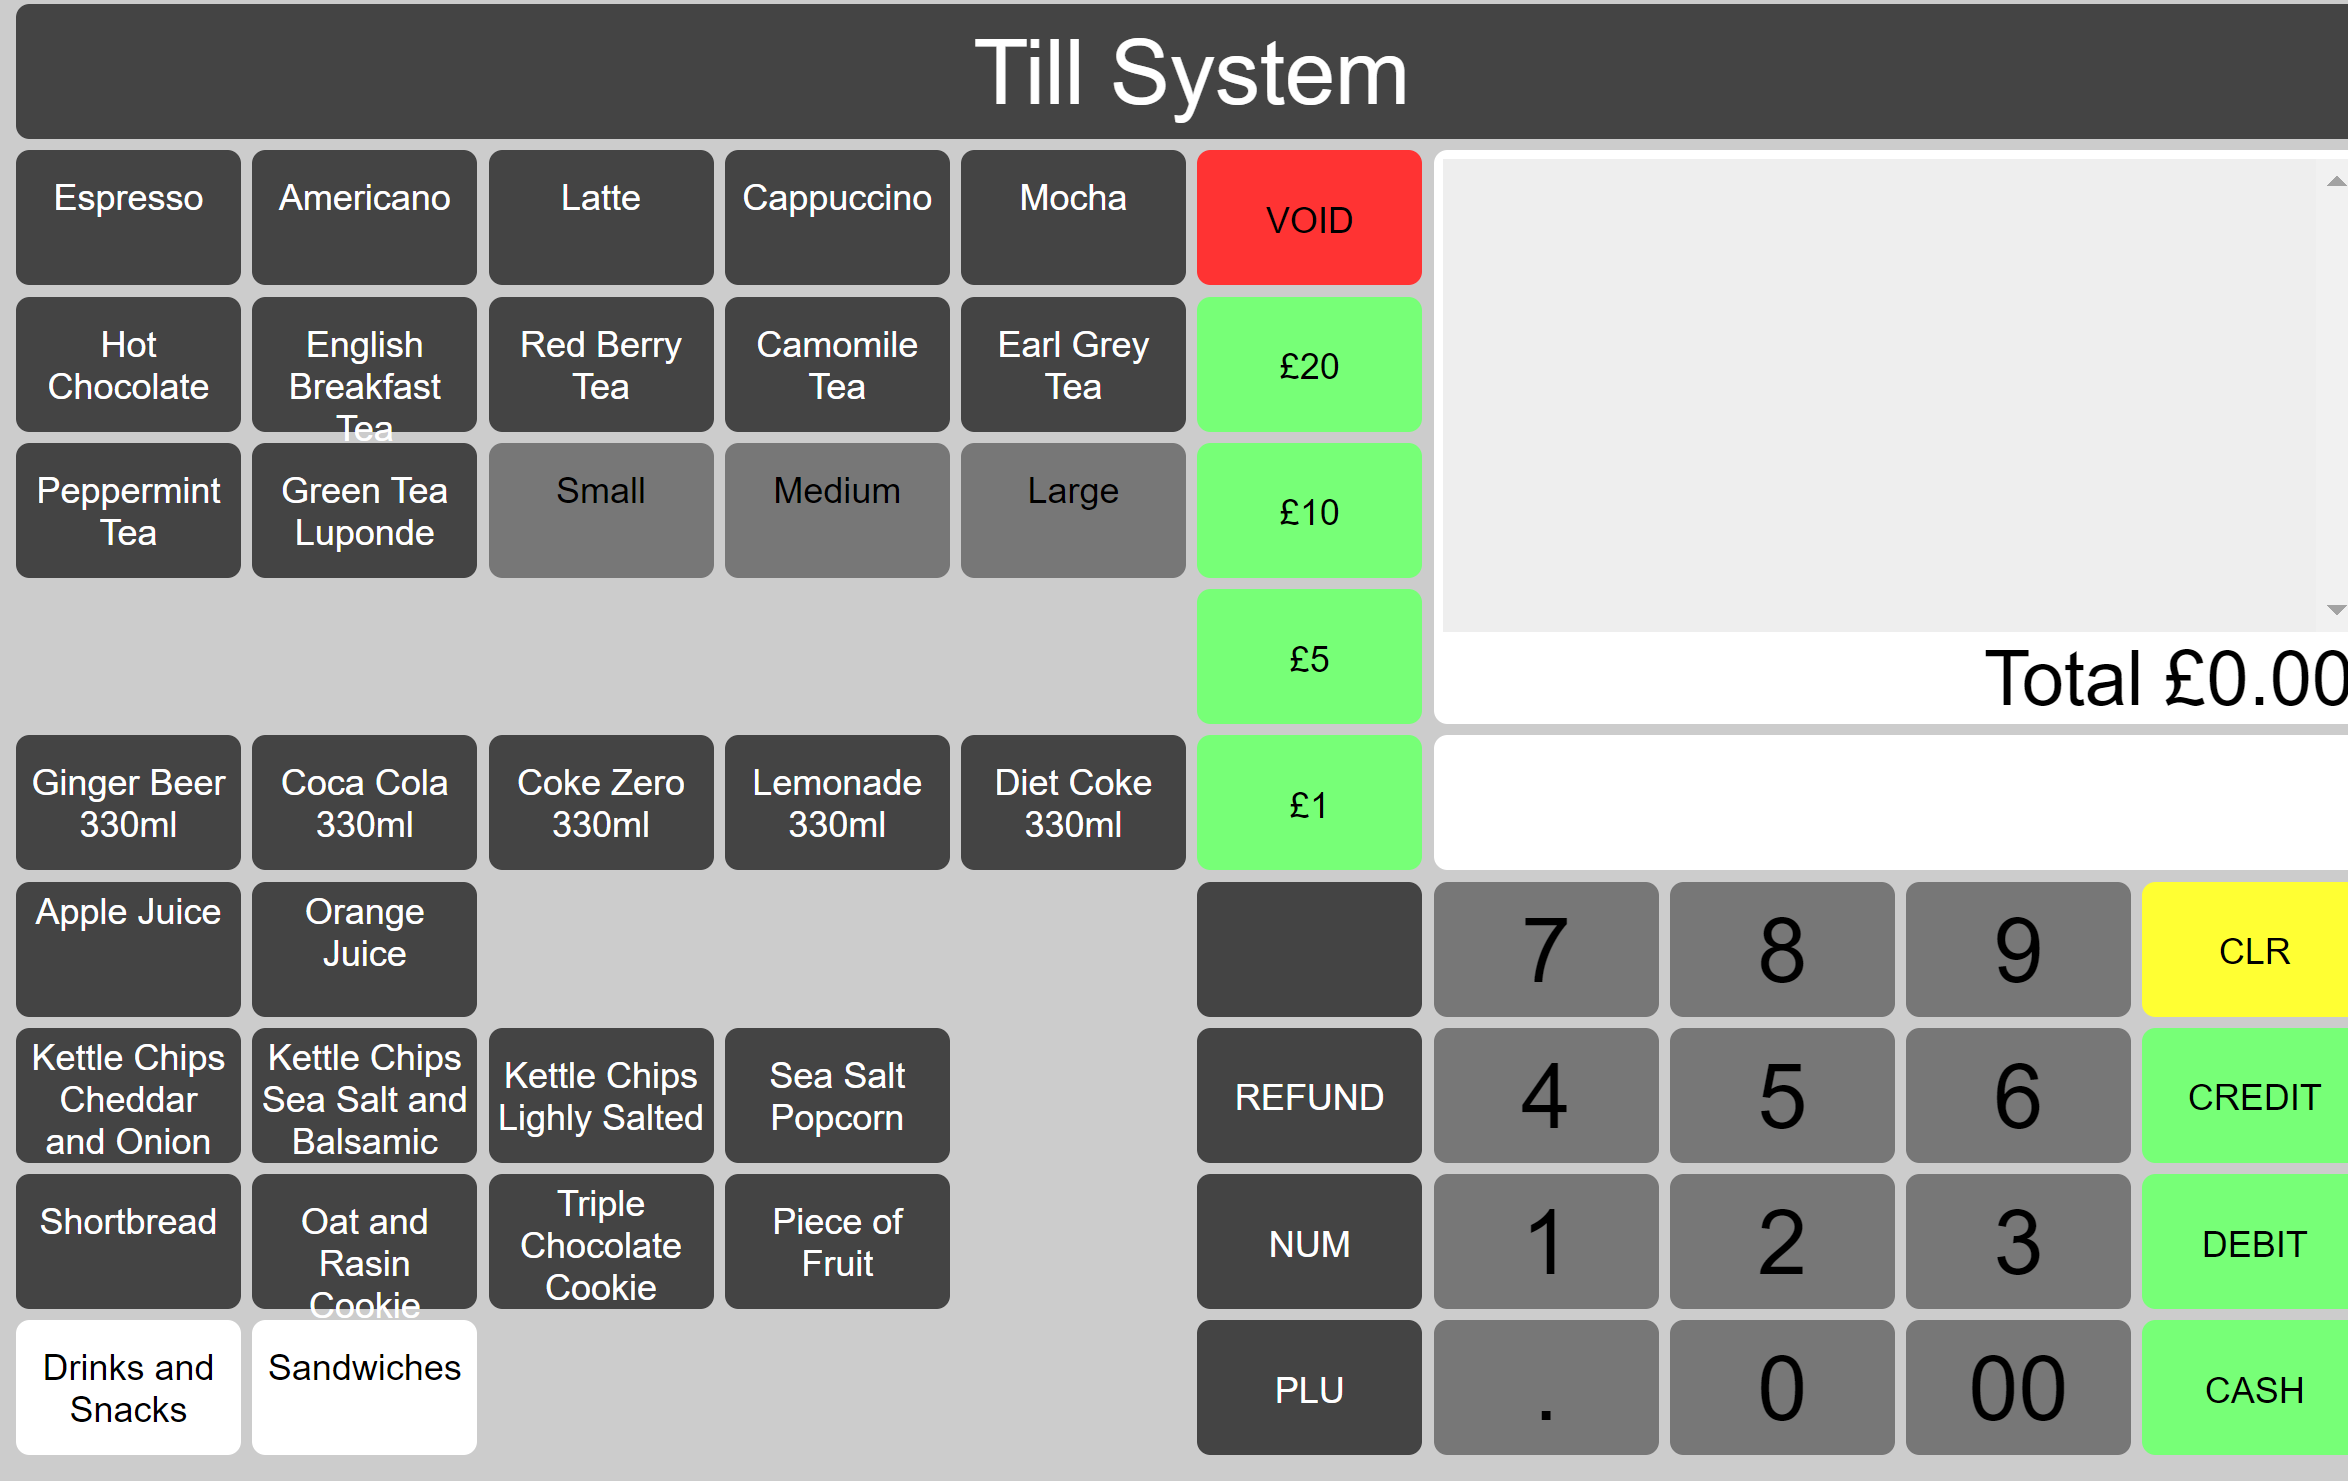

In [4]:
# screenshot of till system

from IPython.display import Image
Image("C:/Users/aksha/github code/mini project submission/till.png", width= 500)


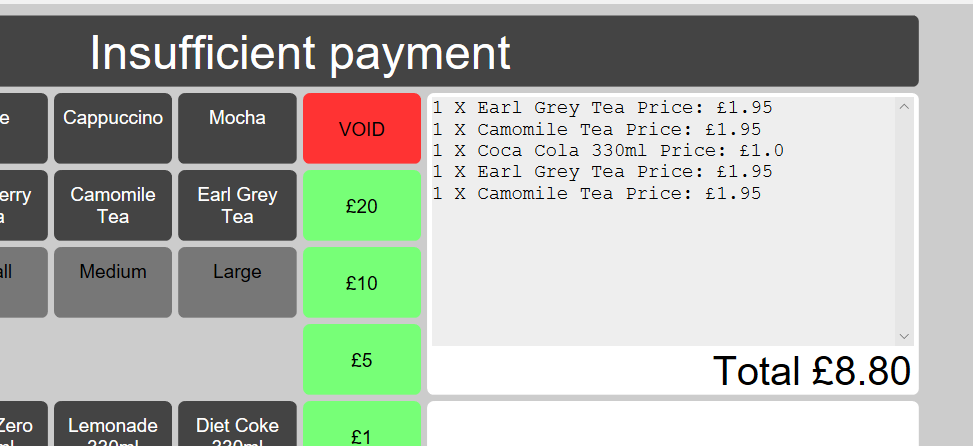

In [5]:
#Screenshot of payment if insufficienct payment

Image("insufficientPayment.png", width= 500)

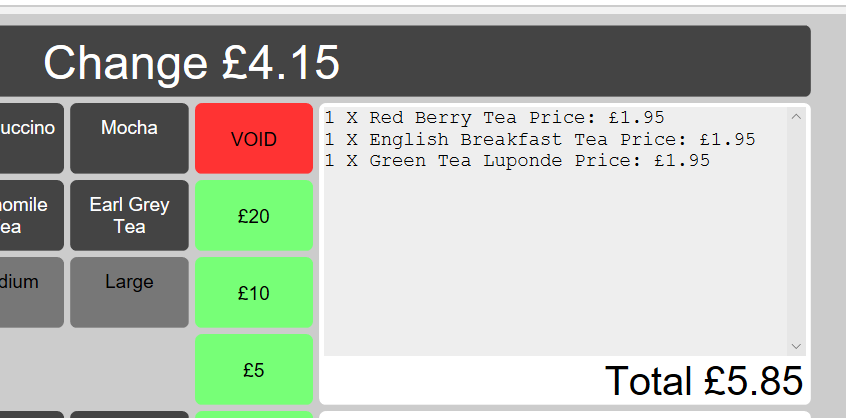

In [6]:
#Screenshot of payment successful payment. Change for the transaction is shown in the title

Image("sufficientPayment.png", width= 500)

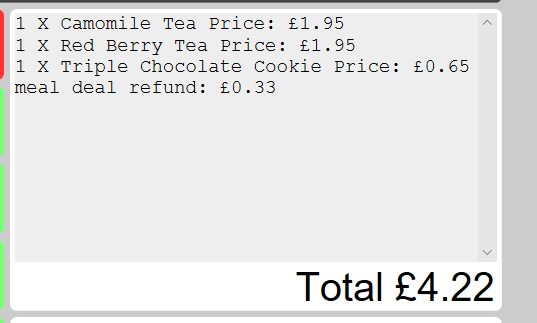

In [7]:
#Meal deal without refund

Image("mealDeal1.png", width= 300)

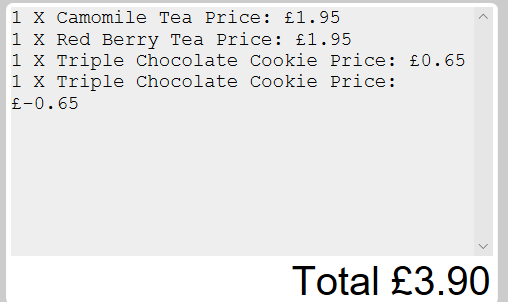

In [8]:
# The cookie is refunded, and meal deal also disappears

Image("mealDeal2.png", width= 300)

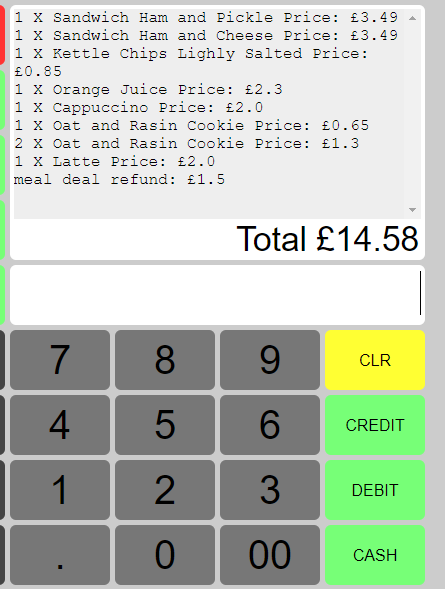

In [9]:
#Multiple meal deals are aggregated together. In this case 2 cookie and one meal deal are calculated

Image("mealDeal3.png", width= 400)

Next we will write queries to keep track of daily activity

In [10]:
db = sqlite3.connect('tillsDb.db')
cursor = db.cursor()

In [11]:
#extract all transactions and sales

cursor.execute("select * from transactions")
transactions =cursor.fetchall()

cursor.execute("select * from sales")
sales = cursor.fetchall()

In [12]:
#code to write to csv
import csv


def writecsv (res, csvfile):
    with open(csvfile, "w") as output:
        writer = csv.writer(output, lineterminator='\n')
        for val in res:
            writer.writerow([val])    

In [ ]:
#write transactions to csv
res = transactions
csvfile = "transOut.csv"
writecsv (res, csvfile)

In [ ]:
#write sales to csv
res = sales
csvfile = "salesOut.csv"
writecsv (res, csvfile)

In [ ]:
#daily Sales report
#how many of each product are sold
#(sales.quantity*sales.price)/products.price) will aggregate refunds away
cursor.execute("select products.name, sum((sales.quantity*sales.price)/products.price), products.price, products.pos FROM (products JOIN sales ON products.productId=sales.productId)\
JOIN transactions on transactions.transactionId =  sales.transactionId GROUP BY products.productid")

dailySalesFull = cursor.fetchall()

#remove refunds
dailySales = [x for x in dailySalesFull if x[1] != float(0)]

print(dailySales)


In [ ]:
#write daily sales to csv
import csv
res = dailySales
csvfile = "dailySales.csv"
writecsv (res, csvfile)

In [ ]:
#calculate total value of sales
import numpy as np

quant = np.array(dailySales[1])
price = np.array(dailySales[2])
totSaleDict = {}
totalSales = 0
for i in dailySales:

    saleVal = i[1]*i[2]

    totSaleDict[i[0]]=saleVal
    totalSales+=saleVal

print(totalSales)


In [ ]:
#cash payments
cursor.execute("select sum(totalCost) from transactions WHERE paymentType = 1")

cash = cursor.fetchone()[0]
print(cash)

In [ ]:
#debit payments
cursor.execute("select sum(totalCost) from transactions WHERE paymentType = 2")
debit = cursor.fetchone()[0]
print(debit)

In [ ]:
#credit payments
cursor.execute("select sum(totalCost) from transactions WHERE paymentType = 3")
credit = cursor.fetchone()[0]
print(credit)

In [ ]:
#calculate all discounts
cursor.execute("select sales.productId, sales.price from sales JOIN transactions ON sales.transactionId = transactions.transactionId WHERE transactions.date = date('now') AND productId in ('MD1','MD2')")

discounts = cursor.fetchall()
print(discounts)

In [ ]:
#sum of discounts
sumdisc = 0
for disc in discounts:
    sumdisc+=abs(disc[1])
print(sumdisc)

In [ ]:
#produce dictionary of discounts

discountIds = {disc[0] for disc in discounts}
discountsDict = {}

discCount = 0
discVal = 0
for i in discountIds:
    discCount = 0
    discVal = 0
    print(i)
    for disc in discounts:

        if i == disc[0]:
            discCount += 1
            discVal+= abs(disc[1])
        discountsDict[i] =(discCount,discVal)
    
print(discountsDict) 


In [ ]:
#calculate the amount of each product purchased in a day

#product can be manually changed
product = "'"+"Coca Cola 330ml"+"'"


cursor.execute("select products.name, sum((sales.quantity*sales.price)/products.price), products.price FROM (products JOIN sales ON products.productId=sales.productId)\
JOIN transactions on transactions.transactionId =  sales.transactionId WHERE transactions.date = date('now') AND products.name = {}".format(product))

print(cursor.fetchall())


In [13]:
# close database
db.close()